## Problem Statement:
NER: Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use.

Leveraging the data of twitter, train models that will be able to identify the various named entities.


In [ ]:
#Importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Funtion to load the data
def load_df(filename:str):
  with open(filename, 'r') as files:
    lines = [line[:-1].split() for line in files]
  data, s = [], 0
  for e, comp in enumerate(lines):
    if not comp:
      dt = [(token, tag) for token, tag in lines[s:e]]
      data.append(dt)
      s = e+1
  if s < e:
    data.append(lines[s:e])
  return data


In [ ]:
#Loading the data using our function
train_data = load_df('wnut 16.txt.conll')
test_data = load_df('wnut 16test.txt.conll')
data = train_data + test_data

In [ ]:
len(data)

6244

In [ ]:
# N is for null tokens
tags= ['N'] + sorted({tag for sentence in data for _,tag in sentence})

In [ ]:
tags

['N',
 'B-company',
 'B-facility',
 'B-geo-loc',
 'B-movie',
 'B-musicartist',
 'B-other',
 'B-person',
 'B-product',
 'B-sportsteam',
 'B-tvshow',
 'I-company',
 'I-facility',
 'I-geo-loc',
 'I-movie',
 'I-musicartist',
 'I-other',
 'I-person',
 'I-product',
 'I-sportsteam',
 'I-tvshow',
 'O']

In [ ]:
#Calculating the maximum length of a sentence
max_len = 0
for sentence in data:
  max_len = max(max_len, len(sentence))
print('maximum length is :', max_len)

maximum length is : 39


In [ ]:
#Calculating vocabulary size
from collections import defaultdict
word_counts = defaultdict(int)
for sentence in data:
  for word in sentence:
    word_counts[word[0]] += 1
no_words = len(word_counts.items())
print('Vocabulary size is:' , no_words)

Vocabulary size is: 25382


In [ ]:
sentence_all = []
for line in data:
  sentence = [part[0] for part in line]
  sentence_all.append(sentence)

### CRF

In [ ]:
#Training a tokenizer
import tensorflow as tf
crf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = no_words, lower = True)
crf_tokenizer.fit_on_texts(sentence_all)

In [ ]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [ ]:
# Embedding the word matrix, intialising with word2vec google news
no_tokens = len(crf_tokenizer.word_index) + 1
hits = 0
misses = 0
word2vec = api.load("glove-twitter-200")
embedding_dim = 200

# Prepare embedding matrix
embedding_matrix = np.zeros((no_tokens, embedding_dim))
for word, i in crf_tokenizer.word_index.items():
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11495 words (10438 misses)


In [ ]:
! pip install keras_preprocessing

In [ ]:
#Creating tag to index
import sklearn

tag2idx = {t: i for i, t in enumerate(tags)}

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
def get_df(data, max_len, tag2idx, tokenizer):
  df = {'data':[], 'labels':[]}
  for sentence in data:
    inputs = [w[0] for w in sentence]
    outputs = [w[1] for w in sentence]
    inputs = tokenizer.texts_to_sequences([inputs])[0]

    padded_inputs = [inputs[i] if i< len(inputs) else 0 for i in range(max_len)]
    padded_labels = [[0 for i in range(len(tag2idx))] for j in range(max_len)]
    for i in range(len(outputs)):
      padded_labels[i][tag2idx[outputs[i]]] = 1

    df['data'].append(padded_inputs)
    df['labels'].append(padded_labels)
  return np.array(df['data']), np.array(df['labels'])

train_sentences, train_labels = get_df(train_data, max_len, tag2idx,crf_tokenizer)
test_sentences, test_labels = get_df(test_data, max_len, tag2idx,crf_tokenizer)

In [ ]:
  ! pip install tensorflow_addons

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model():
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim = embedding_matrix.shape[0],
      output_dim = embedding_dim,
      input_length=max_len,
      mask_zero=True,
      embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)
       )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  #output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  #mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(len(tags), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 200)           4386800   
                                                                 
 bidirectional (Bidirection  (None, 39, 100)           100400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 39, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 39, 25)            2525      
 ributed)                                                        
                                                             

In [ ]:
history = model.fit(
  train_sentences,
  train_labels,
  epochs = 400,
  validation_data=(test_sentences, test_labels),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/400


75/75 [==============================] - ETA: 0s - loss: 0.0885
Epoch 1: val_loss improved from inf to 0.08759, saving model to ner_crf.h5
75/75 [==============================] - 42s 185ms/step - loss: 0.0885 - val_loss: 0.0876
Epoch 2/400
75/75 [==============================] - ETA: 0s - loss: 0.0409
Epoch 2: val_loss improved from 0.08759 to 0.06704, saving model to ner_crf.h5
75/75 [==============================] - 3s 36ms/step - loss: 0.0409 - val_loss: 0.0670
Epoch 3/400
73/75 [============================>.] - ETA: 0s - loss: 0.0318
Epoch 3: val_loss improved from 0.06704 to 0.04613, saving model to ner_crf.h5
75/75 [==============================] - 3s 36ms/step - loss: 0.0316 - val_loss: 0.0461
Epoch 4/400
75/75 [==============================] - ETA: 0s - loss: 0.0261
Epoch 4: val_loss improved from 0.04613 to 0.04235, saving model to ner_crf.h5
75/75 [==============================] - 4s 49ms/step - loss: 0.0261 - val_loss: 0.0423
Epoch 5/400
74/75 [=======================

In [ ]:
model.load_weights('ner_crf.h5')
crf_model = tf.keras.Model(inputs = model.input, outputs = [model.output, model.get_layer('crf').output, model.input])

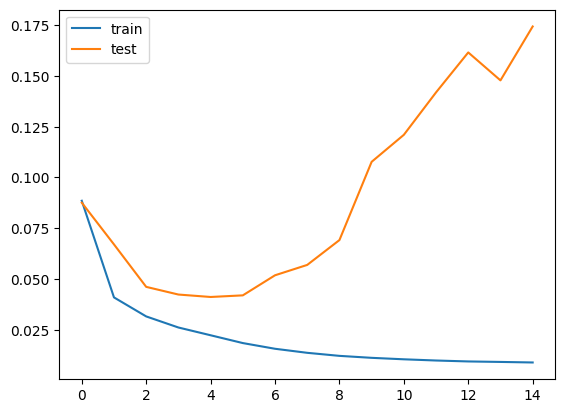

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

121/121 [==============================] - 6s 8ms/step


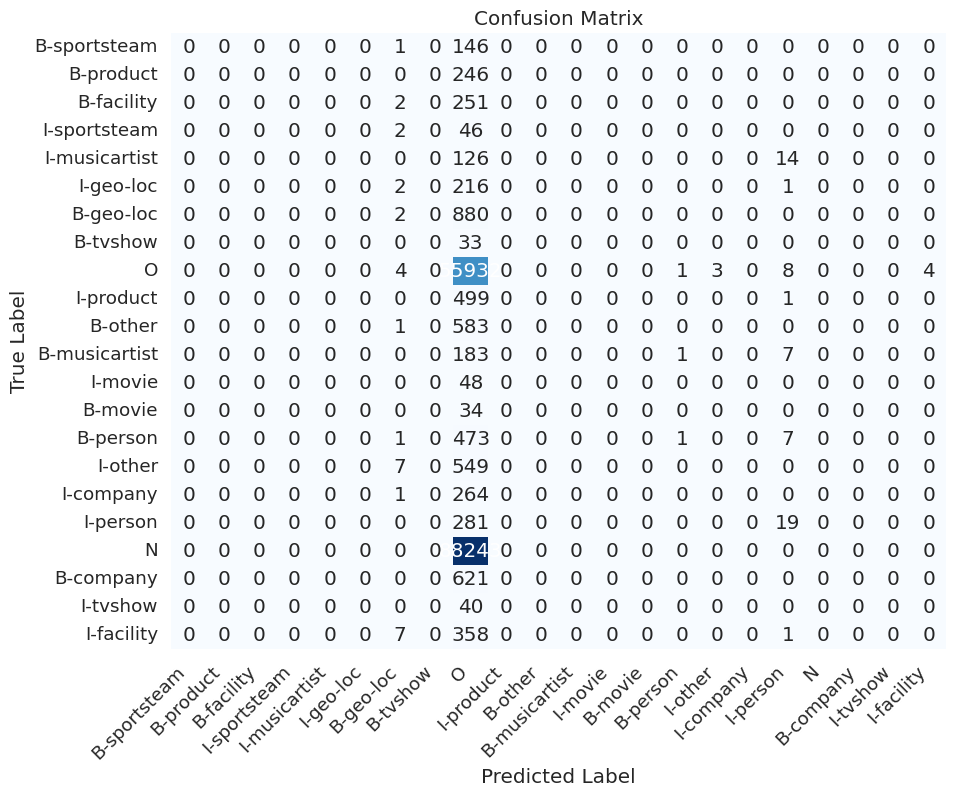

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(test_sentences)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in test_labels for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                 precision    recall  f1-score   support

 B-sportsteam       0.00      0.00      0.00         0
    B-product       0.00      0.00      0.00         0
   B-facility       0.00      0.00      0.00         0
 I-sportsteam       0.00      0.00      0.00         0
I-musicartist       0.00      0.00      0.00         0
    I-geo-loc       0.00      0.00      0.00         0
    B-geo-loc       0.00      0.07      0.00        30
     B-tvshow       0.00      0.00      0.00         0
            O       1.00      0.37      0.54    150052
    I-product       0.00      0.00      0.00         0
      B-other       0.00      0.00      0.00         0
B-musicartist       0.00      0.00      0.00         0
      I-movie       0.00      0.00      0.00         0
      B-movie       0.00      0.00      0.00         0
     B-person       0.00      0.33      0.00         3
      I-other       0.00      0.00      0.00         3
    I-company       0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### BERT(Transformers)

In [ ]:
! pip install transformers
! pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import AutoTokenizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
Model = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(Model)

In [ ]:
  sample = train_data[10] #Random tokenized sample
  for token, tag in sample:
    for subtoken in tokenizer(token)['input_ids'][1:-1]:
      print(token, subtoken)

RT 19387
@Hatshepsutely 1030
@Hatshepsutely 16717
@Hatshepsutely 5369
@Hatshepsutely 4523
@Hatshepsutely 10421
@Hatshepsutely 2135
: 1024
@adamlambert 1030
@adamlambert 4205
@adamlambert 10278
@adamlambert 8296
please 3531
, 1010
oh 2821
please 3531
wear 4929
the 1996
infamous 14429
beach 3509
hat 6045
tonight 3892
during 2076
your 2115
encore 19493
( 1006
in 1999
lieu 22470
of 1997
a 1037
rasta 20710
rasta 2696
wig) 24405
wig) 1007
. 1012
&lt; 1004
&lt; 8318
&lt; 1025
3333 21211
3333 2509


In [ ]:
def tokenize_sample(sample):

  #sentence, tags = sample # unpack the sample tuple
  #tokens = tokenizer.tokenize(sentence) # split the sentence into tokens
  subtokens = [] # initialize an empty list for subtokens
  subtags = [] # initialize an empty list for subtags
  #for token, tag in zip(tokens, tags): # iterate over the tokens and tags
  for sentence in sample:
    for token, tag in sentence:
      for subtoken in tokenizer(token)['input_ids'][1:-1]:
        if token.startswith('##'): # check if the token is a subword
          subtokens.append(token) # append the token to the subtokens list
          subtags.append('X') # append a special tag 'X' to the subtags list
        else: # otherwise, the token is a word
          subtokens.append(token) # append the token to the subtokens list
          subtags.append(tag) # append the tag to the subtags list
  subtoken_ids = tokenizer.convert_tokens_to_ids(subtokens) # convert the subtokens to numerical IDs
  return list(zip(subtoken_ids, subtags)) # return a list of tuples of subtoken IDs and tags

In [ ]:
def tokenize_sample(sample):
  seq = [(subtoken, tag) for token, tag in sample
         for subtoken in tokenizer(token.lower())['input_ids'][1:-1]]
  return [(3, 'O')] + seq + [(4, 'O')]


In [ ]:
def preprocess(samples, tag2id):
  tokenized_samples = list(map(tokenize_sample, samples))
  max_len = max(map(len, tokenized_samples))

  X_input_ids = np.zeros((len(samples), max_len), dtype = np.int32)

  X_input_masks = np.zeros((len(samples), max_len), dtype = np.int32)

  y =  np.zeros((len(samples),max_len), dtype = np.int32)

  for i, sentence in enumerate(tokenized_samples):
    for j in range(len(sentence)):
      X_input_masks[i,j] = 1
    for j, (subtoken_id, tag) in enumerate(sentence):
      X_input_ids[i,j] = subtoken_id
      y[i,j] = tag2id[tag]
  return (X_input_ids, X_input_masks), y

X_train, y_train = preprocess(train_data, tag2idx)
X_test, y_test = preprocess(test_data, tag2idx)


In [ ]:
#Loading model
from transformers import AutoConfig, TFAutoModelForTokenClassification

config = AutoConfig.from_pretrained(Model, num_labels=len(tags), id2tag = idx2tag, tag2id = tag2idx)
model = TFAutoModelForTokenClassification.from_pretrained(Model, config = config)
model.summary()

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108908566 (415.45 MB)
Trainable params: 108908566 (415.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Fitting the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
batch_size = 32
model.compile(optimizer = optimizer , loss = loss, metrics = metric)

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 10, batch_size = batch_size)

Epoch 1/10
60/60 [==============================] - 104s 617ms/step - loss: 0.3641 - accuracy: 0.9018 - val_loss: 0.1195 - val_accuracy: 0.9815
Epoch 2/10
60/60 [==============================] - 37s 624ms/step - loss: 0.0957 - accuracy: 0.9810 - val_loss: 0.0814 - val_accuracy: 0.9823
Epoch 3/10
60/60 [==============================] - 33s 557ms/step - loss: 0.0663 - accuracy: 0.9844 - val_loss: 0.0754 - val_accuracy: 0.9832
Epoch 4/10
60/60 [==============================] - 35s 587ms/step - loss: 0.0473 - accuracy: 0.9888 - val_loss: 0.0691 - val_accuracy: 0.9843
Epoch 5/10
60/60 [==============================] - 36s 593ms/step - loss: 0.0324 - accuracy: 0.9919 - val_loss: 0.0682 - val_accuracy: 0.9854
Epoch 6/10
60/60 [==============================] - 35s 585ms/step - loss: 0.0230 - accuracy: 0.9946 - val_loss: 0.0686 - val_accuracy: 0.9873
Epoch 7/10
60/60 [==============================] - 35s 591ms/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.0707 - val_accuracy: 0.986


*   Let's have a side by side view of true labels and model predictions
*   Arrange as an array of tuple(token, true label, model prediction)



In [ ]:
def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
    nr_subtoken = len(tokenizer(token.lower())['input_ids']) -2
    pred = predictions[i:i+nr_subtoken]
    i += nr_subtoken
    y_pred =  tags[np.argmax(np.sum(pred, axis = 0))]
    results.append((token, y_true, y_pred))
  return results

y_probs = model.predict(X_test)[0]
predictions = [aggregate(sample, predictions) for sample, predictions in zip(test_data, y_probs)]


121/121 [==============================] - 47s 357ms/step


In [ ]:
for i in range(10, 15):
  print(predictions[i])

[('I', 'O', 'O'), ('drive', 'O', 'O'), ('by', 'O', 'O'), ('that', 'O', 'O'), ('motel', 'O', 'O'), ('almost', 'O', 'O'), ('every', 'O', 'O'), ('night', 'O', 'O'), ('.', 'O', 'O'), ('#MesaShooting', 'O', 'O')]
[('Apple', 'B-product', 'B-product'), ('MacBook', 'I-product', 'I-product'), ('Pro', 'I-product', 'I-product'), ('A1278', 'I-product', 'I-product'), ('13.3', 'I-product', 'O'), ('"', 'I-product', 'O'), ('Laptop', 'I-product', 'O'), ('-', 'I-product', 'O'), ('MD101LL/A', 'I-product', 'O'), ('(', 'O', 'O'), ('June', 'O', 'O'), (',', 'O', 'O'), ('2012', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O'), ('Full', 'O', 'O'), ('read', 'O', 'O'), ('by', 'O', 'O'), ('eBay', 'B-company', 'B-company'), ('http://t.co/2zgQ99nmuf', 'O', 'O'), ('http://t.co/eQmogqqABK', 'O', 'O')]
[('Tuff', 'B-musicartist', 'B-other'), ('Culture', 'I-musicartist', 'I-other'), ('-', 'O', 'O'), ('Destiny', 'B-product', 'B-other'), ('EP', 'O', 'O'), ('(', 'O', 'O'), ('PAR', 'O', 'O'), ('042', 'O', 'O'), ('FORTHCOMING', '

In [ ]:
model.save_pretrained('output/NER_pretrained')

### Comparision

In [ ]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids']
  ner_tokens = [3]  #Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1])
  ner_tokens += [4] #End token
  return ner_tokens

In [ ]:
sentence = 'apple macbook pro is the best laptop in the word'

#Bert_tokenization
bert_token = tokenize_bert(sentence)

#CRF_tokenization
crf_tokens = crf_tokenizer.texts_to_sequences([sentence])

In [ ]:
def align_labels_to_input(sentence, predictions):
  sentence_token = sentence.lower().split(" ")
  results = []

  i = 1
  for token in sentence_token:
    nr_subtoken = len(tokenizer(token)['input_ids']) -2
    pred = predictions[i:i+nr_subtoken]
    i += nr_subtoken
    y_pred =  idx2tag[np.argmax(np.sum(pred, axis = 0))]
    results.append((token, y_pred))
  return results

bert_logits = model.predict([bert_token], verbose = 0).logits
align_labels_to_input(sentence, bert_logits[0])

[('apple', 'B-product'),
 ('macbook', 'I-product'),
 ('pro', 'I-product'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('word', 'O')]

In [ ]:
#CRF output
from pprint import pprint

crf_padded_tokens = [[crf_tokens[0][x] if x < len(crf_tokens[0]) else 0 for x in range(39)]]
crf_preds, _, _, _ = crf_model.predict(crf_padded_tokens, verbose = 0)[1]

crf_preds = [idx2tag[x] for x in crf_preds[0]]  # Convert indices into predictions

#Get alligned input with labels
input_word_tokens = [crf_tokenizer.sequences_to_texts([[x]])[0] for x in crf_padded_tokens[0]]

#Only printing non_padded tokens with their labels
pprint(list(zip(input_word_tokens[:len(crf_tokens[0])], crf_preds[:len(crf_tokens[0])])))

[('apple', 'O'),
 ('macbook', 'I-product'),
 ('pro', 'B-product'),
 ('is', 'B-musicartist'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'B-person'),
 ('word', 'O')]


## Questions and Answers:

1. Defining the problem statements and where can this and modifications of this be used?

  Ans:

  Problem statement:
  NER: Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use.

  Leveraging the data of twitter, train models that will be able to identify the various named entities.
  
  NER can be used for various applications, such as:

  •  Content classification: to understand the content themes and categories based on the named entities.

  •  Question answering: to find the best answer based on the relevant entities in a question and a text.

  •  Information retrieval: to improve the search results by using the named entities as keywords or filters.

  •  Machine translation: to improve the quality and accuracy of machine translation by identifying and preserving the named entities in the source and target languages.

  •  Data analysis: to extract and organize data from various sources and use them for further analysis and visualization.

2. Explain the data format (conll bio format).

 Ans:  The CoNLL BIO format, often referred to simply as the BIO format, is a commonly used data format for representing annotated sequences, such as named entity recognition (NER) or part-of-speech tagging tasks. It stands for "Begin, Inside, Outside" and is an extension of the CoNLL format used for tabular data.

  In the BIO format, each token in a sequence is assigned a tag that indicates its role in a specific
  task (e.g., identifying named entities in text). The format uses the following labels:

  B-label: Indicates the beginning of an entity of the specified label.
  I-label: Indicates an inside (or intermediate) token of an entity of the specified label.
  O: Indicates a token that is outside of any entity.
  label: Represents an entity that spans a single token.

3. What other ner data annotation formats are available and how are they different.

  Ans: Apart from the CoNLL BIO format, several other data annotation formats are used for Named Entity Recognition (NER). Each format has its own characteristics and purposes. Here are a few other NER data annotation formats:

  **IOB (Inside-Outside-Beginning):**

  Similar to BIO format, but instead of "B-" and "I-" prefixes, it uses "I-" and "O-".
  "I-" marks tokens inside an entity, "O-" marks tokens outside of any entity, and "B-" marks the beginning of an entity.

  **IOB2 (Inside-Outside-Beginning 2):**

  A variation of the IOB format.
  It uses "B-" for the beginning of an entity, and "I-" for both inside tokens and the inside of consecutive entities.

  **IOBES (Inside-Outside-Beginning-End-Single):**

  An extension of IOB that includes additional tags for the end of an entity ("E-") and single-token entities ("S-").

  **BIOUL (Beginning, Inside, Outside, Unit, Last):**

  Similar to BIO, but with additional tags.
  "U-" is used for single-token entities, and "L-" marks the last token of an entity.

  **Brackets Annotation:**

  Entities are marked using brackets, with the entity label followed by the text span.
  For example: "[ORG Microsoft] released [DATE Windows 10] ."

  **XML or HTML Annotation:**

  Entities are annotated using XML or HTML tags within the text.
  For example:
  xml
  Copy code
  <text> <ORG>Microsoft</ORG> released <DATE>Windows 10</DATE> . </text>
  
  **Standoff Annotation:**

  Annotations are stored separately from the text in an annotation file.
  The text file and annotation file are linked using character offsets or unique identifiers.

  **Brat Annotation Format:**

  Used by the Brat annotation tool.
  Combines standoff annotation with an indexing mechanism for faster access.

  The choice of annotation format depends on factors such as the annotation tool being used, compatibility with downstream processing, and personal preference. BIO and its variations (IOB, IOB2, IOBES) are commonly used due to their simplicity and compatibility with many machine learning frameworks.

4. Why do we need tokenization of the data in our case

  Ans: Tokenization is a crucial preprocessing step in Natural Language Processing (NLP) that involves breaking down a text into individual units, usually words or subwords. In the context of Named Entity Recognition (NER), tokenization is essential for several reasons:

  **Isolating Entities:** NER aims to identify and classify named entities within a text. Tokenization helps in isolating individual words or subwords, making it easier to recognize where an entity starts and ends.

  **Segmenting Text:** Text often contains punctuation marks, spaces, and special characters. Tokenization segments the text into meaningful units that can be individually analyzed.

  **Standardization:** Tokenization ensures that the text is standardized into a format that machine learning models can process consistently. Each token can be assigned a specific label or feature, which is necessary for training a model.

5. What other models can you use for this task

  Ans: We can use models like BiLSTM, CNN and Flair for this NER task.

6. Did early stopping have any effect on the training and results.

  Ans: Yes, early stopping can have a significant effect on the training and results of neural networks. Early stopping can help to prevent overfitting, which is when the model learns the noise in the training data and performs poorly on new data. By monitoring the performance of the model on a validation set during training, early stopping can stop the training process when the model starts to lose generalization ability.

7. How does the BERT model expect a pair of sentences to be processed?

  Ans: The BERT model expects a pair of sentences to be processed in a specific way. The sentences are concatenated with a special token [SEP] between them, and another special token [CLS] is added at the beginning of the sequence. The tokens are then converted into numerical IDs using a vocabulary file, and a segment embedding is added to indicate which sentence each token belongs to. Additionally, a positional embedding is added to capture the order of the tokens. The resulting sequence of embeddings is then fed into the BERT model as input.

8. Why choose Attention based models over Recurrent based ones?

  Ans: • Attention based models use attention to focus on relevant parts of the input or output sequence.

  •  Recurrent based models process the input or output sequence one token at a time.

  •  Attention based models are faster, better at long-term dependencies, and more interpretable than recurrent based models.

9. Differentiate BERT and simple transformers

  Ans: • BERT is a pre-trained model that uses the encoder part of the transformer and can be fine-tuned for natural language understanding tasks. BERT is bidirectional and trained on masked language modeling and next sentence prediction .

  •  Simple transformers is a library that provides an easy interface for training and evaluating various transformer-based models, including BERT and others. Simple transformers also supports natural language generation tasks .

  •  BERT and simple transformers differ in their abstraction, complexity, flexibility, convenience, and performance. BERT requires more coding and customization, while simple transformers provides more default options and speed. The performance may depend on the task, data, and parameters.
